In [1]:
!git checkout craft-update 

Already on 'craft-update'
Your branch is up to date with 'origin/craft-update'.


In [2]:
from annealed_flow_transport.train import run_experiment
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from annealed_flow_transport.many_well_plotting import plot
from annealed_flow_transport.densities import ManyWell
from annealed_flow_transport.resampling import log_effective_sample_size

/homes/lim24/miniconda3/envs/jax/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-28 15:12:46.546622: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-28 15:12:46.546774: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-28 15:12:46.546789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned ab

In [3]:
original_setup = True # whether to run Alex's original config, or a config that is more similar to FAB's setup.
if original_setup:
    from configs.many_well_original import get_config
    exp_config = get_config()
    exp_config.n_samples_plotting = 100
else:
    from configs.many_well import get_config
    exp_config = get_config()
    exp_config.craft_num_iters = 1000
    exp_config.report_step = 100

In [9]:
exp_config.num_temps, exp_config.flow_config.type

(11, 'SplineInverseAutoregressiveFlow')

In [10]:
n_mill_target_eval = exp_config.craft_batch_size*exp_config.craft_num_iters*exp_config.num_temps*exp_config.mcmc_config.hmc_num_leapfrog_steps/1e6
n_mill_target_eval

44.0

In [11]:
!rm checkpoint_craft_mw_original

rm: cannot remove 'checkpoint_craft_mw_original': No such file or directory


In [12]:
!rm checkpoint_craft_mw

rm: cannot remove 'checkpoint_craft_mw': No such file or directory


  0%|                                                   | 0/200 [00:00<?, ?it/s]

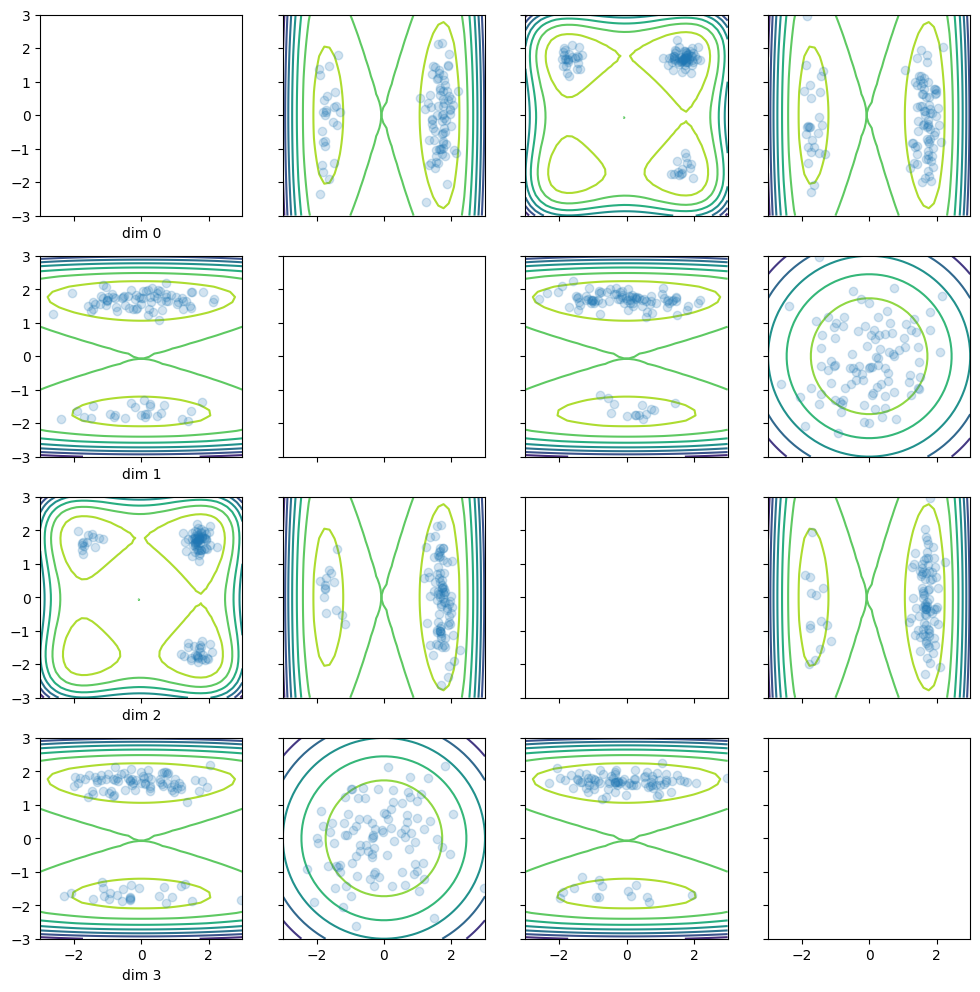

  0%|▏                                          | 1/200 [00:15<52:02, 15.69s/it]

effective sample size of 0.9999998807907104
Step 0: Free energy -157.56015014648438 Log Normalizer estimate 163.17323303222656


 16%|██████▉                                   | 33/200 [00:21<00:28,  5.93it/s]

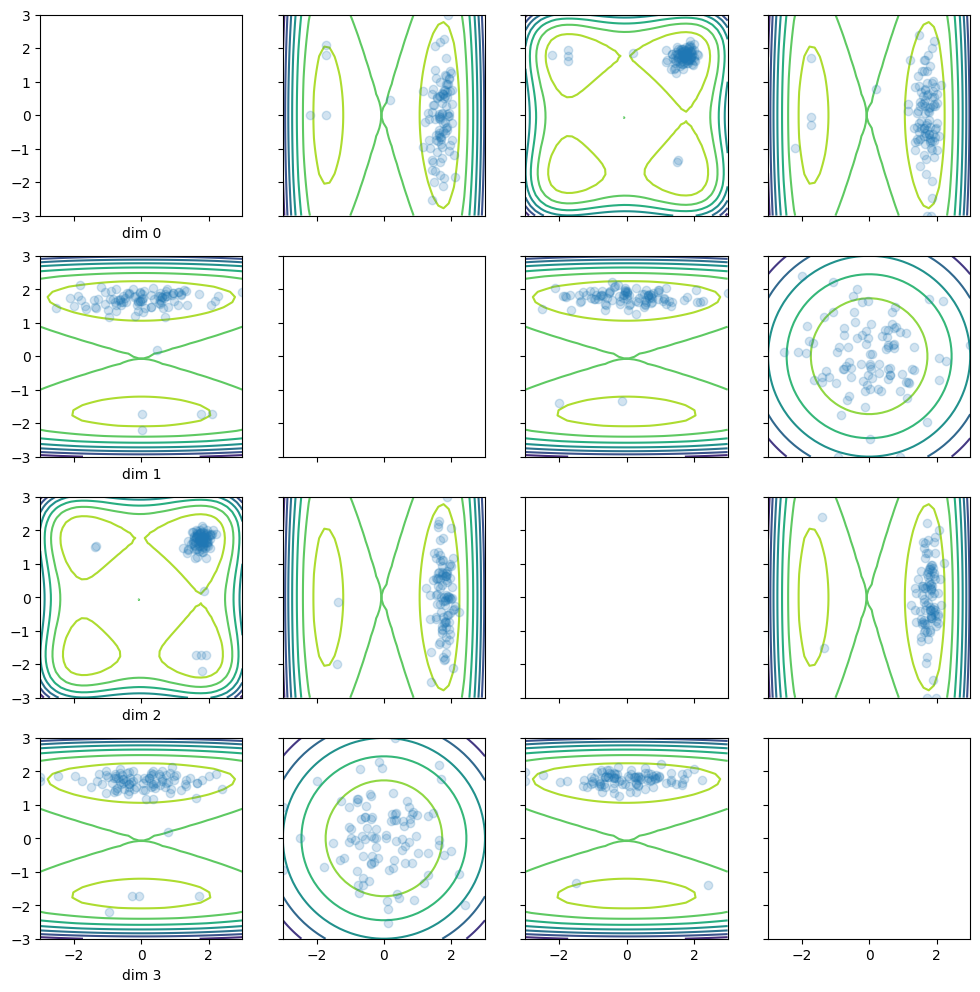

 17%|███████▏                                  | 34/200 [00:33<10:35,  3.83s/it]

effective sample size of 0.9999998807907104
Step 33: Free energy -162.53736877441406 Log Normalizer estimate 165.64633178710938


 33%|█████████████▊                            | 66/200 [00:39<00:22,  5.88it/s]

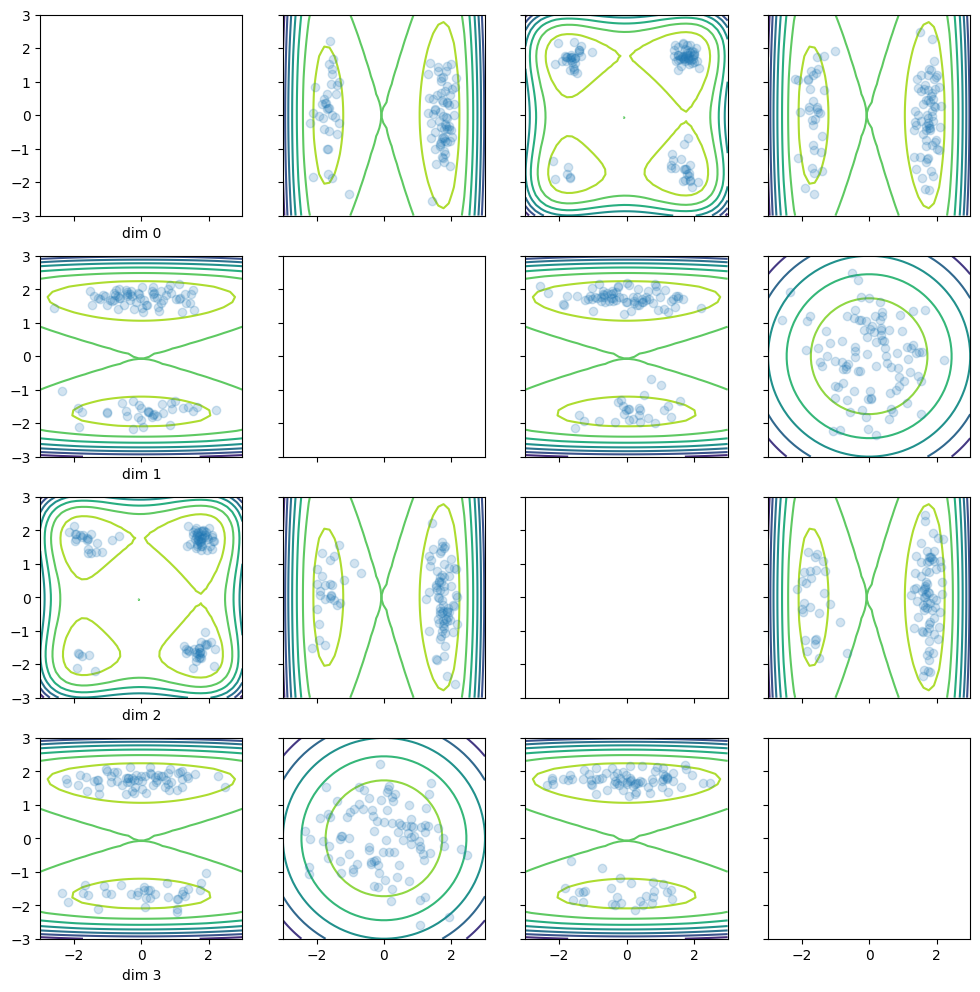

 34%|██████████████                            | 67/200 [00:50<08:13,  3.71s/it]

effective sample size of 0.7069608569145203
Step 66: Free energy -162.29251098632812 Log Normalizer estimate 164.34967041015625


 50%|████████████████████▊                     | 99/200 [00:56<00:17,  5.89it/s]

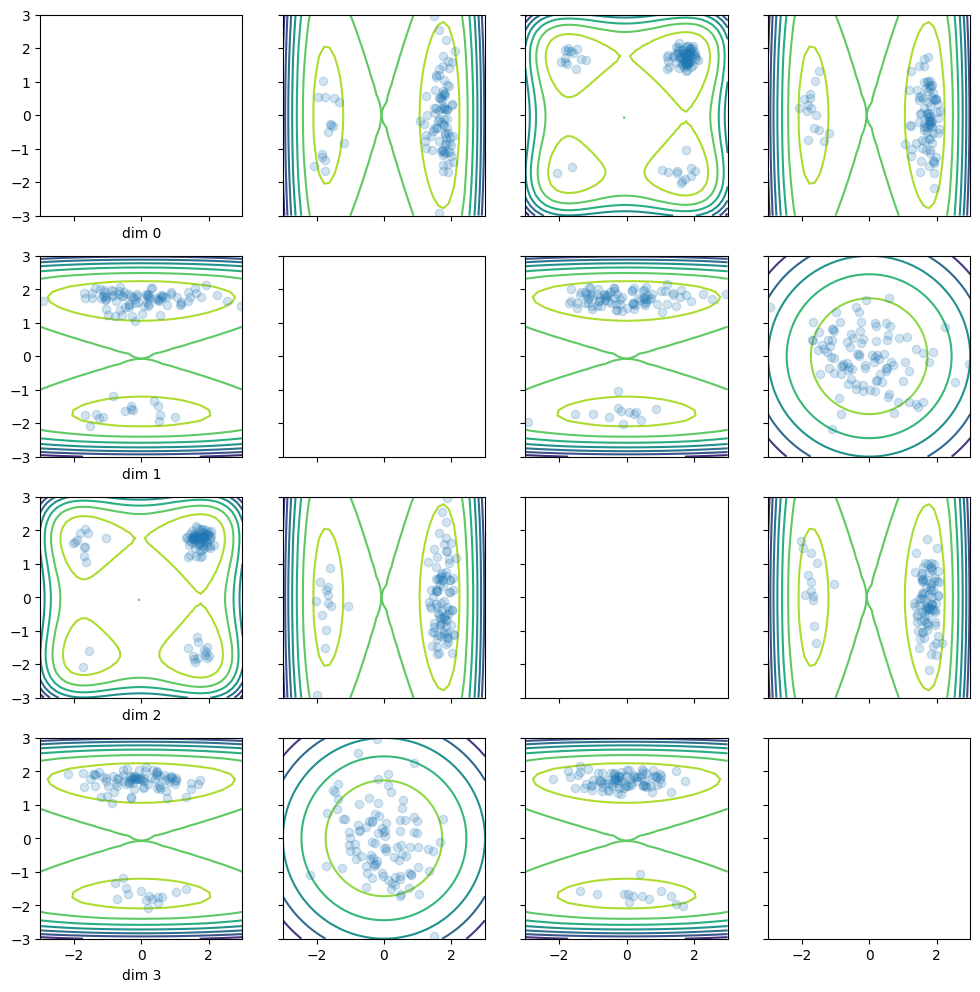

 50%|████████████████████▋                    | 101/200 [01:08<04:24,  2.67s/it]

effective sample size of 0.9999998807907104
Step 99: Free energy -162.9429473876953 Log Normalizer estimate 164.55499267578125


 66%|███████████████████████████              | 132/200 [01:14<00:11,  5.83it/s]

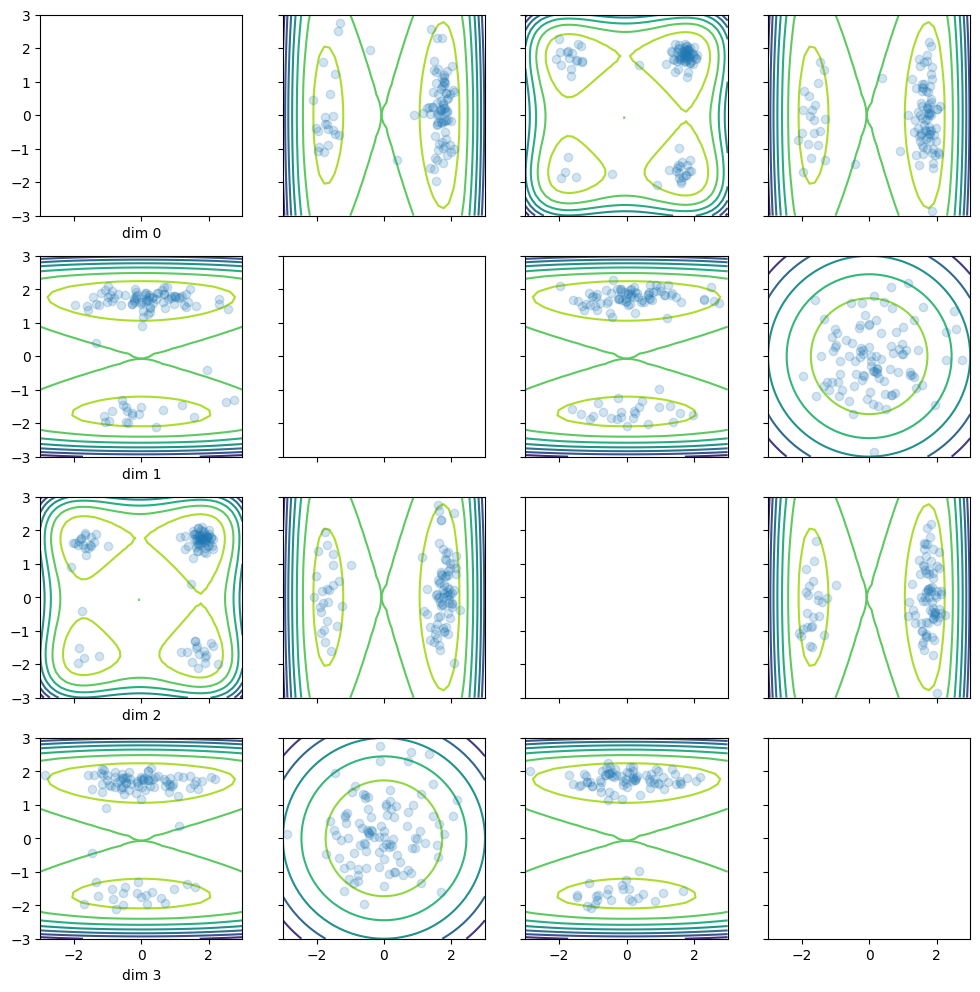

 66%|███████████████████████████▎             | 133/200 [01:26<04:10,  3.74s/it]

effective sample size of 0.46419039368629456
Step 132: Free energy -163.88729858398438 Log Normalizer estimate 165.28900146484375


 82%|█████████████████████████████████▊       | 165/200 [01:31<00:05,  5.87it/s]

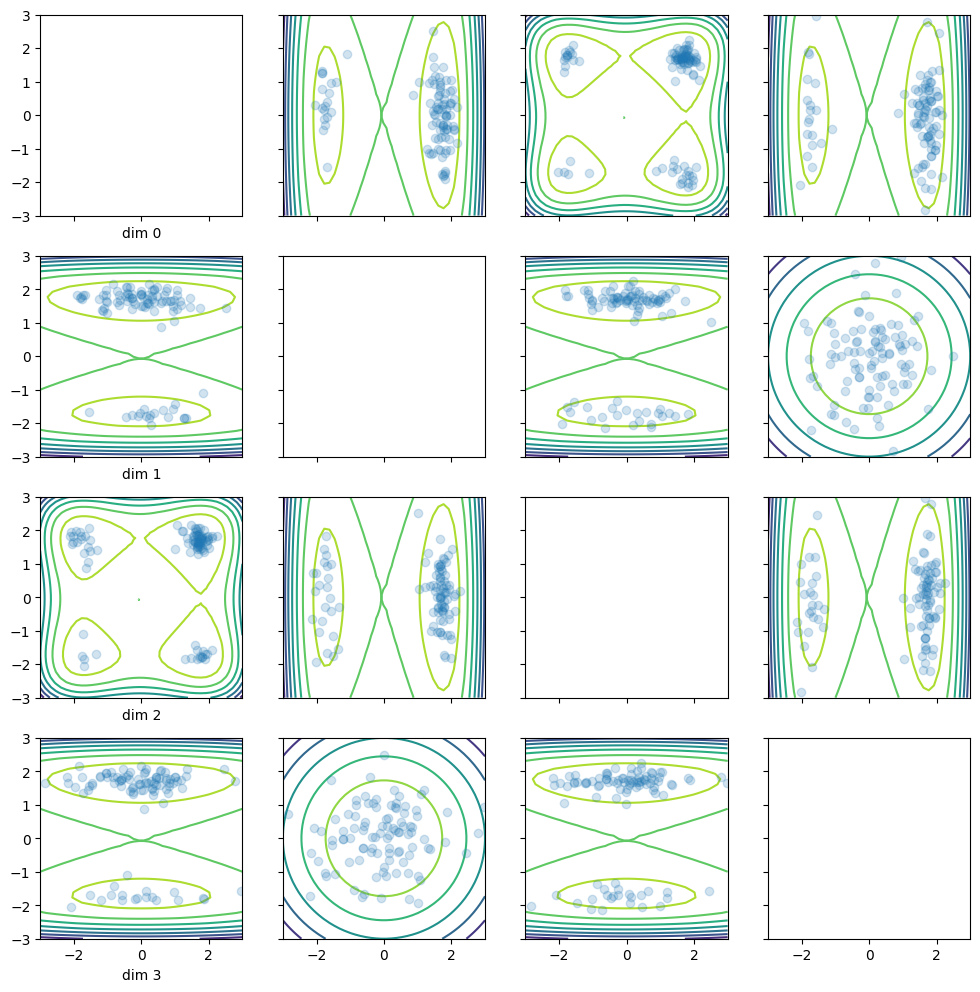

 83%|██████████████████████████████████       | 166/200 [01:43<02:05,  3.70s/it]

effective sample size of 0.9174567461013794
Step 165: Free energy -163.42919921875 Log Normalizer estimate 164.53070068359375


 99%|████████████████████████████████████████▌| 198/200 [01:49<00:00,  5.92it/s]

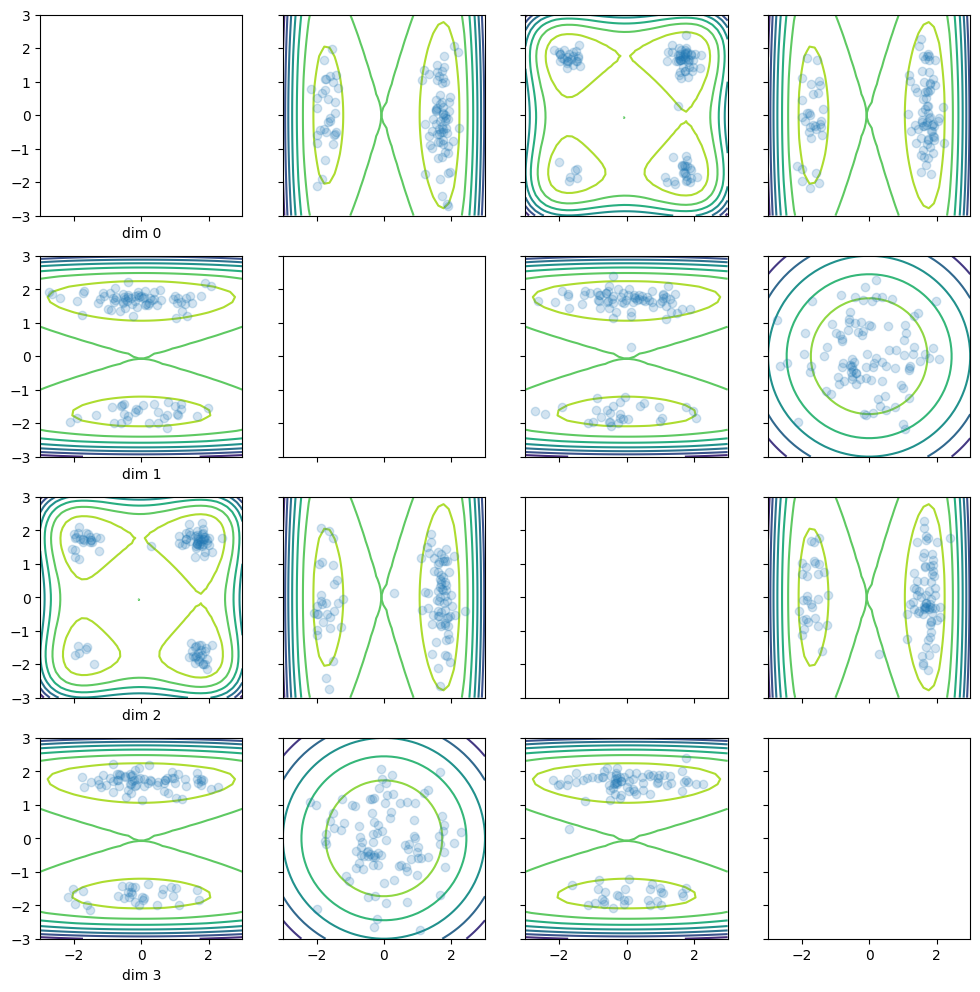

100%|█████████████████████████████████████████| 200/200 [02:01<00:00,  1.65it/s]

effective sample size of 0.3250995874404907
Step 198: Free energy -163.66445922851562 Log Normalizer estimate 164.7188262939453


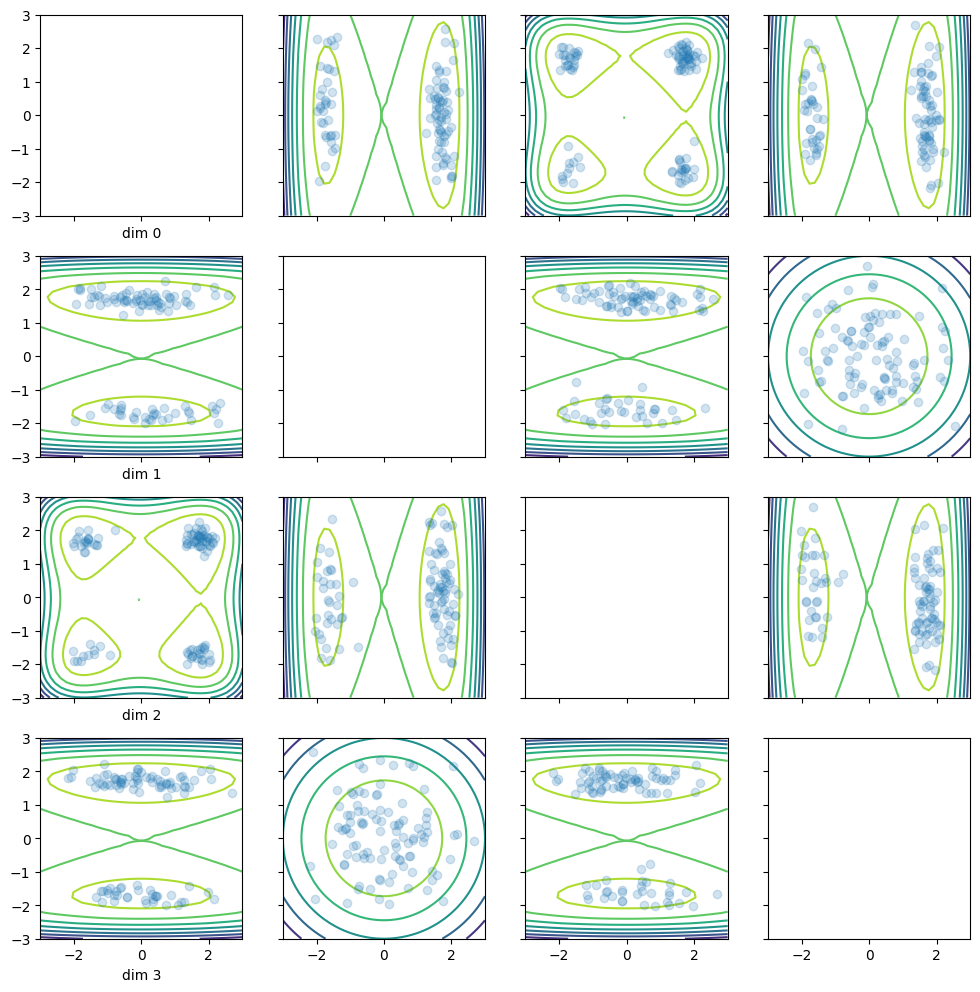

In [13]:
results = run_experiment(exp_config)

# Preliminary Evaluation

In [14]:
target_density = ManyWell(exp_config.final_config.density, (32,))

In [15]:
# n_plotting_samples = 1000
# plot(results.test_samples[:n_plotting_samples], target_density.evaluate_log_density, 8)

In [16]:
results.log_normalizer_estimate, target_density.log_Z

(Array(164.37517, dtype=float32), 164.6956753197969)

In [17]:
results.test_log_weights

Array([-7.1271296, -9.819322 , -7.582576 , ..., -7.9628344, -5.9496946,
       -5.6570997], dtype=float32)

In [18]:
1 / jnp.sum(jax.nn.softmax(results.test_log_weights) ** 2) / results.test_log_weights.shape[0]

Array(0.33047912, dtype=float32)

In [19]:
jnp.exp(log_effective_sample_size(results.test_log_weights)) / results.test_log_weights.shape[0]

Array(0.3304791, dtype=float32)

# Proper evaluation

# Load model

In [4]:
from evaluation import evaluate_many_well, load_checkpoint, make_forward_pass_func, \
    make_get_ess, make_get_resample_info

In [5]:
if original_setup:
    filename = 'checkpoint_craft_mw_original'
else:
    filename = "checkpoint_craft_mw"
transition_params = load_checkpoint(filename)

### Evalation of full craft

In [40]:
exp_config.use_resampling = True
exp_config.use_markov = True

In [6]:
eval_batch_size = int(1e4) # exp_config.batch_size

forward_pass_function = make_forward_pass_func(exp_config, transition_params=transition_params,
                                              eval_batch_size=eval_batch_size)

In [7]:
eval_info = evaluate_many_well(forward_pass_function, n_runs=20)

In [8]:
eval_info['ess']

Array([0.9999999 , 0.9178887 , 0.91105795, 0.9131183 , 0.9164176 ,
       0.90893334, 0.92144966, 0.9999999 , 0.9184071 , 0.9999999 ,
       0.9105972 , 0.9137598 , 0.9113939 , 0.9179667 , 0.9224533 ,
       0.9999999 , 0.3165438 , 0.9114443 , 0.92330915, 0.9253844 ],      dtype=float32)

In [9]:
jnp.sum(eval_info['ess'] > 0.999)

Array(4, dtype=int32)

In [10]:
jnp.unique(eval_info['log_w'][1]).shape

(8953,)

Text(0.5, 1.0, 'effective sample size')

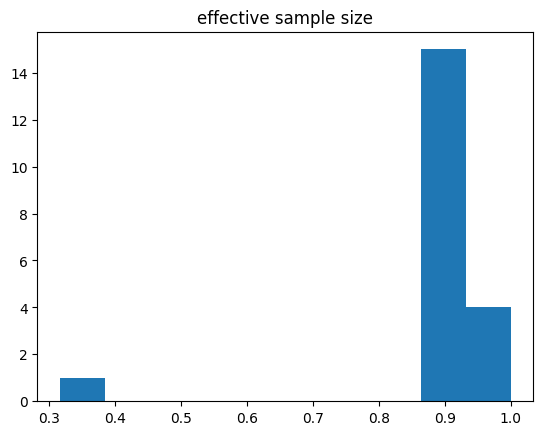

In [11]:
plt.hist(eval_info['ess'])
plt.title("effective sample size")

# Without resampling

In [6]:
exp_config.use_resampling = False
exp_config.use_markov = True

eval_batch_size = exp_config.batch_size
if original_setup:
    filename = 'checkpoint_craft_mw_original'
else:
    filename = "checkpoint_craft_mw"
transition_params = load_checkpoint(filename)
forward_pass_function = make_forward_pass_func(exp_config, transition_params=transition_params,
                                              eval_batch_size=eval_batch_size)

eval_info = evaluate_many_well(forward_pass_function, n_runs=20)

eval_info['ess']

Array([0.00394454, 0.0306855 , 0.00768863, 0.02421386, 0.02376493,
       0.03299804, 0.02851554, 0.01804564, 0.01448242, 0.01127135,
       0.02167689, 0.026447  , 0.03031969, 0.01623734, 0.0207822 ,
       0.0191378 , 0.01694544, 0.01365601, 0.02038491, 0.01308394],      dtype=float32)

In [7]:
eval_info['log_w']

Array([[-15.469393 , -10.1651535, -14.5349045, ...,  -7.9117446,
         -9.895126 , -12.485853 ],
       [-12.079209 , -10.084144 ,  -5.9336004, ..., -16.364838 ,
        -11.629737 , -12.878392 ],
       [-15.340048 , -13.174183 , -19.291044 , ..., -11.370199 ,
        -32.0129   ,  -8.46928  ],
       ...,
       [-12.027281 , -10.770742 ,  -7.5247464, ..., -12.693531 ,
        -13.474949 , -11.232941 ],
       [-13.4268675,  -9.626172 , -13.750438 , ..., -11.9601755,
        -10.764077 ,  -4.843547 ],
       [-10.305763 , -12.269779 , -11.058659 , ..., -20.215263 ,
         -9.94405  , -11.161121 ]], dtype=float32)

# Evaluate resampling

In [8]:
exp_config.use_resampling = True
exp_config.use_markov = True
eval_batch_size = exp_config.batch_size

In [9]:
get_resample_info_fn = make_get_resample_info(config=exp_config, transition_params=transition_params,
                                        eval_batch_size=eval_batch_size)

In [12]:
resample_info = get_resample_info_fn(jax.random.PRNGKey(0))
log_w = resample_info['log_weights']
ess = jnp.exp(log_effective_sample_size(log_w)) / log_w.shape[0]
print(ess)

0.91961324


In [13]:
resample_info

{'n_unique_samples_hist': [1178,
  1133,
  1074,
  983,
  874,
  1177,
  1047,
  870,
  736,
  1233],
 'log_weights': Array([-7.2152686, -7.4732394, -7.4813647, ..., -7.706716 , -7.559467 ,
        -7.3919597], dtype=float32),
 'ess': [Array(0.81704503, dtype=float32),
  Array(0.69526327, dtype=float32),
  Array(0.5881154, dtype=float32),
  Array(0.44173333, dtype=float32),
  Array(0.2864461, dtype=float32),
  Array(0.8213419, dtype=float32),
  Array(0.5519303, dtype=float32),
  Array(0.34402853, dtype=float32),
  Array(0.20592006, dtype=float32),
  Array(0.91961324, dtype=float32)]}

In [28]:
for i, ess in enumerate(resample_info['ess']):
    ess_str = "{:.2f}".format(float(ess))
    print(f"Transport step {i+1}: ess of {ess_str}")
    if ess < exp_config.resample_threshold:
        print("**resampling occured**")

Transport step 1: ess of 0.82
Transport step 2: ess of 0.70
Transport step 3: ess of 0.59
Transport step 4: ess of 0.44
Transport step 5: ess of 0.29
**resampling occured**
Transport step 6: ess of 0.82
Transport step 7: ess of 0.55
Transport step 8: ess of 0.34
Transport step 9: ess of 0.21
**resampling occured**
Transport step 10: ess of 0.92


# Eval flow layer by layer

In [32]:
exp_config.use_resampling, exp_config.use_markov
eval_batch_size = 10000

In [33]:
get_ess_per_layer_fn = make_get_ess(config=exp_config, transition_params=transition_params,
                                        eval_batch_size=eval_batch_size)

In [34]:
ess_per_step = get_ess_per_layer_fn(jax.random.PRNGKey(0))

In [35]:
ess_per_step

[Array(0.82492036, dtype=float32),
 Array(0.8667207, dtype=float32),
 Array(0.87017846, dtype=float32),
 Array(0.8466649, dtype=float32),
 Array(0.82006735, dtype=float32),
 Array(0.8297933, dtype=float32),
 Array(0.8523229, dtype=float32),
 Array(0.8830662, dtype=float32),
 Array(0.8989772, dtype=float32),
 Array(0.91924244, dtype=float32)]

In [36]:
jnp.prod(jnp.stack(ess_per_step))

Array(0.22294958, dtype=float32)

## Evaluation of flow only forward pass without resampling

In [119]:
exp_config.use_resampling = False
exp_config.use_markov = False

In [120]:
eval_batch_size = exp_config.batch_size
if original_setup:
    filename = 'checkpoint_craft_mw_original'
else:
    filename = "checkpoint_craft_mw"
transition_params = load_checkpoint(filename)
forward_pass_function = make_forward_pass_func(exp_config, transition_params=transition_params,
                                              eval_batch_size=eval_batch_size)

In [121]:
eval_info = evaluate_many_well(forward_pass_function, n_runs=20)

In [122]:
eval_info['ess']

Array([0.00555046, 0.0156328 , 0.01282621, 0.00685868, 0.00863306,
       0.01119422, 0.0087122 , 0.01681587, 0.00319299, 0.01414286,
       0.00769478, 0.00223315, 0.01343279, 0.00350951, 0.00455144,
       0.01924044, 0.01961836, 0.00870824, 0.01029427, 0.01225321],      dtype=float32)

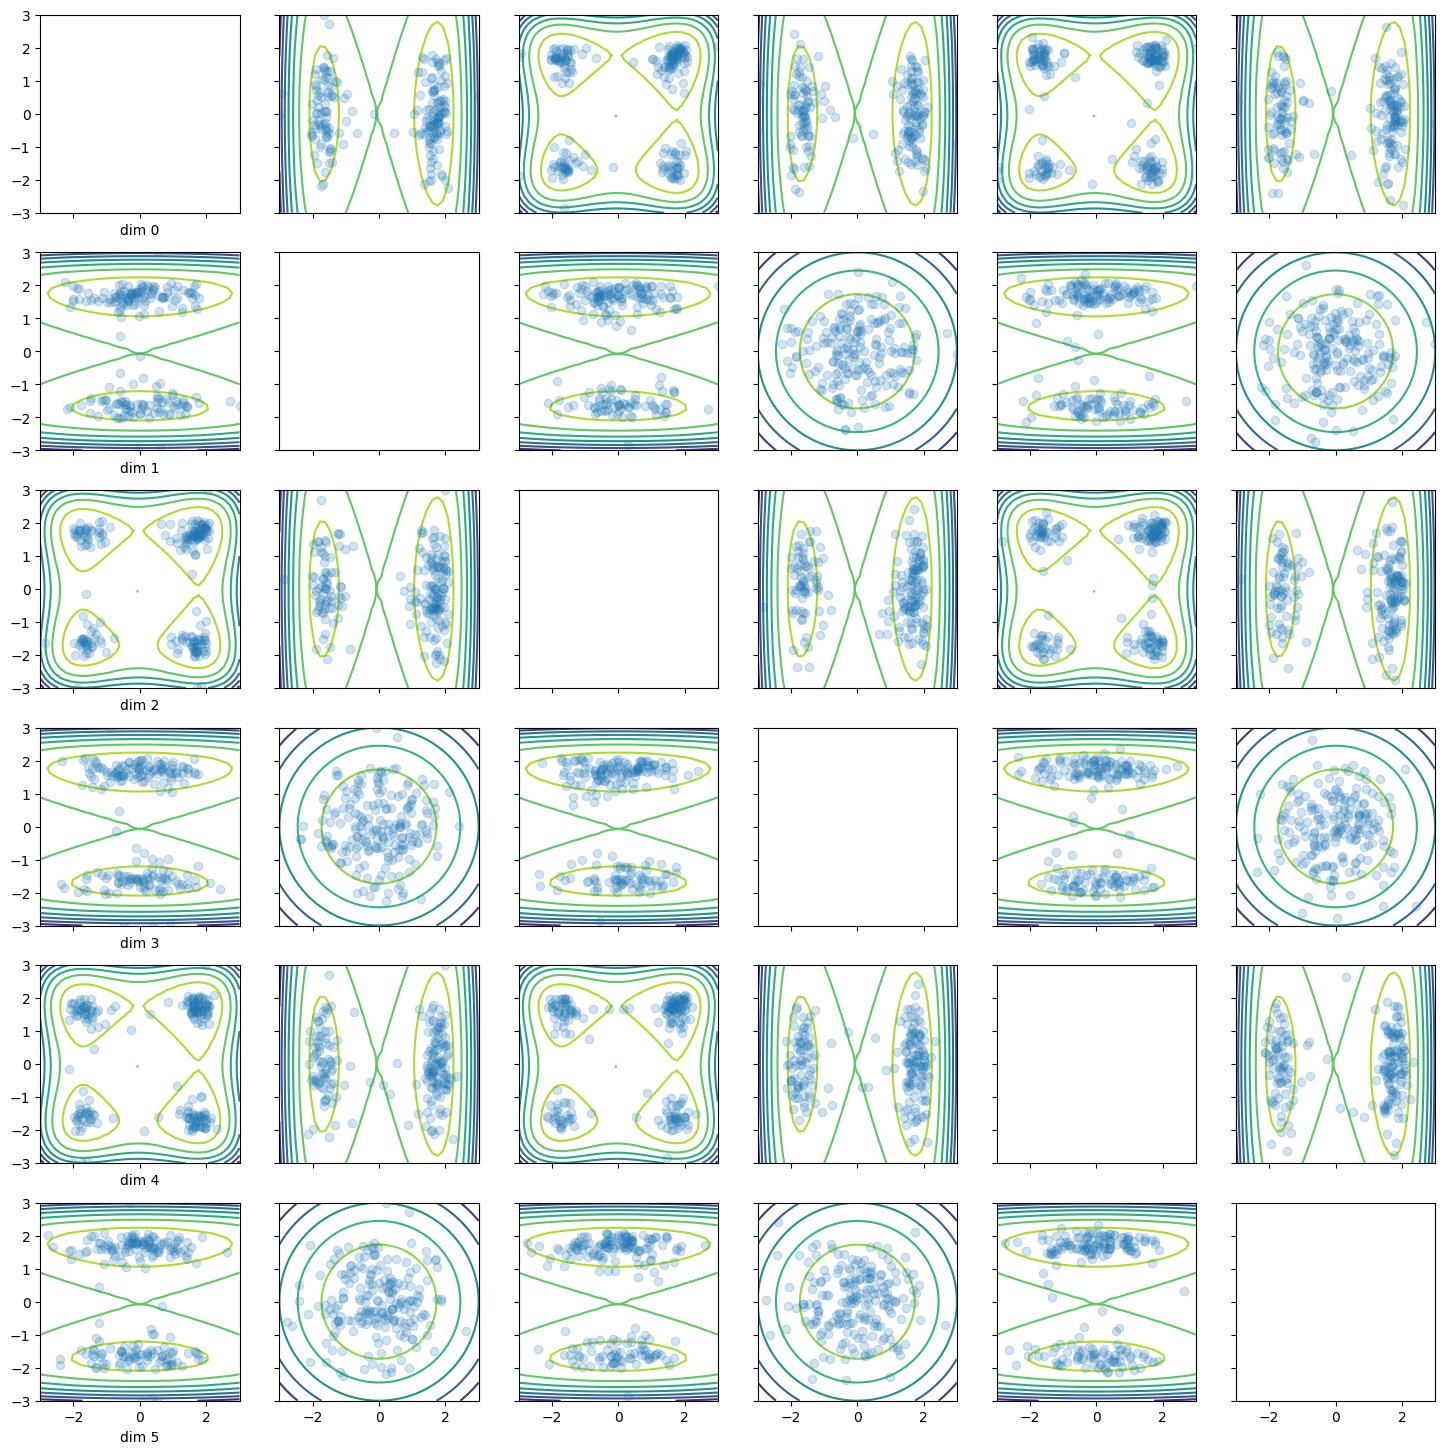

In [123]:
plot(eval_info['x'][0][0:200], target_density, 6)

### Evaluate first layer of the flow

In [151]:
from evaluation import setup_basic_objects
import haiku as hk
from annealed_flow_transport.craft import craft_evaluation_loop, ParticleState, \
    flow_transport
from annealed_flow_transport import markov_kernel
from functools import partial

In [132]:
config = exp_config
config.craft_batch_size = eval_batch_size
num_temps = config.num_temps

initial_sampler, log_density_initial, log_density_final, flow_func = \
    setup_basic_objects(config)

flow_forward_fn = hk.without_apply_rng(hk.transform(flow_func))
flow_apply = flow_forward_fn.apply
log_density_by_step = flow_transport.GeometricAnnealingSchedule(
    log_density_initial, log_density_final, num_temps)
markov_kernel_by_step = markov_kernel.MarkovTransitionKernel(
    config.mcmc_config, log_density_by_step, num_temps)

In [139]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
initial_samples = initial_sampler(subkey, config.craft_batch_size,
                                    config.sample_shape)
flow_samples, log_det_jacs = flow_apply(jax.tree_map(lambda x: x[0], transition_params), initial_samples)

In [140]:
flow_samples.shape, log_det_jacs.shape

((2000, 32), (2000,))

In [143]:
step = 1
log_density_values_current = log_density_by_step(step, flow_samples)
log_density_values_previous = log_density_by_step(step-1, initial_samples)

In [149]:
log_w = log_density_values_current - (log_density_values_previous - log_det_jacs)

In [150]:
jnp.exp(log_effective_sample_size(log_w)) / log_w.shape[0]

Array(0.81705165, dtype=float32)

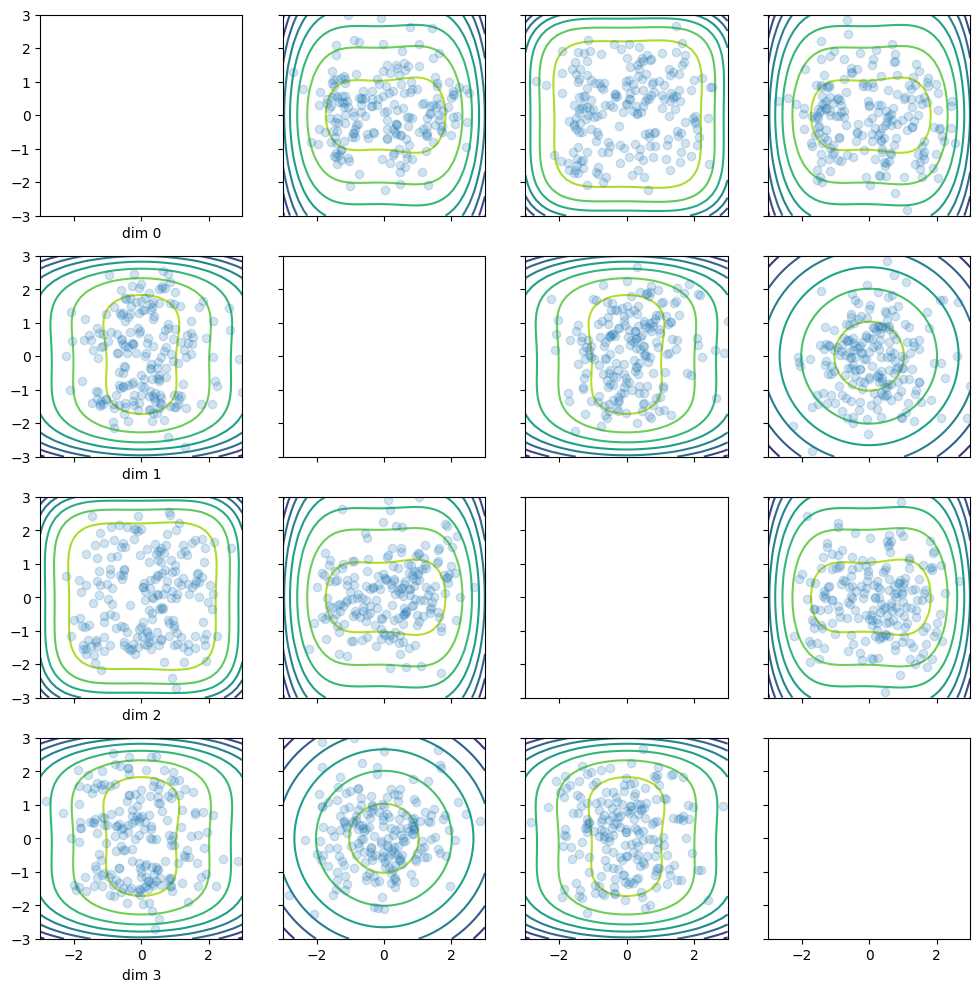

In [153]:
plot(flow_samples[0:200], partial(log_density_by_step, 1), 4)